In [1]:
from jax import numpy as jnp, random, jit
import thermox
import diffrax
from time import time
import matplotlib.pyplot as plt

We want to simulate an OU process
$$
dx = -A(x-b)dt + \mathcal{N}(0, Ddt)
$$
and compare `thermox` and `diffrax` for a varying number of timesteps.


`thermox` simulates OU processes *exactly*, whilst [`diffrax`](https://github.com/patrick-kidger/diffrax)
is a differential equation library that uses discretization to
*approximately* simulate general ODEs and SDEs (thus `diffrax` has a broader scope but
still represents the most natural open source comparison for simulating OU processes
with JAX).

In [2]:
# Define dimension
dim = 100

In [3]:
# Master key
key = random.PRNGKey(0)

In [4]:
# Function to generate a random wishart matrix
def sample_wishart(key, dim, df):
    G = random.normal(key, (dim, df))
    return G @ G.T

In [5]:
# Generate A from Wishart distribution
key, A_key = random.split(key)
df_A = 10
A = sample_wishart(A_key, dim, df_A)

# Perturb to ensure it is positive definite
A += 1e-3 * jnp.eye(dim)


In [6]:
# Generate x0 and b from normal distribution
key, x0_key, b_key = random.split(key, 3)
x0 = random.normal(x0_key, (dim,))
b = random.normal(b_key, (dim,))

In [7]:
# Identity D
D = jnp.eye(dim)
D_sqrt = jnp.linalg.cholesky(D)

In [8]:
# Function to simulate from thermox
@jit
def simulate_thermox(rk, ts):
    return thermox.sample(rk, ts, x0, A, b, D, False)

@jit
def simulate_thermox_as(rk, ts):
    return thermox.sample(rk, ts, x0, A, b, D, True)

In [9]:
# Function to simulate from diffrax
@jit
def simulate_diffrax(rk, ts):
    # From https://docs.kidger.site/diffrax/usage/getting-started/#stochastic-differential-equations-sdes
    def drift(t, y, args):
        return -A @ (y - b)
    def diffusion(t, y, args):
        return D_sqrt
    brownian_motion = diffrax.VirtualBrownianTree(ts[0], ts[-1], tol=1e-3, shape=(dim,), key=rk)
    terms = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, brownian_motion))
    solver = diffrax.ItoMilstein()
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, ts[0], ts[-1], y0=x0, saveat=saveat,
                               dt0=0.01, max_steps=10000000
                               )
    return sol.ys

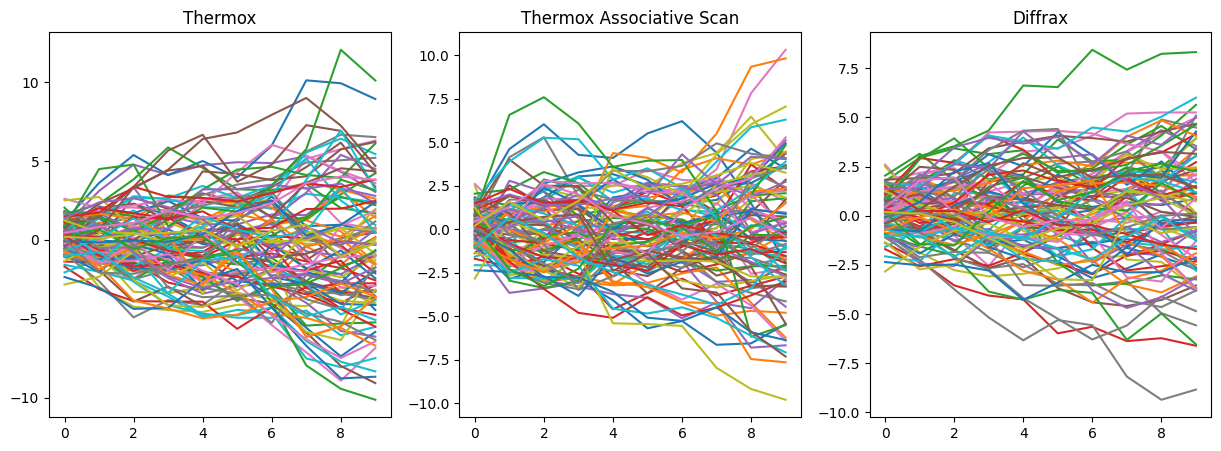

In [10]:
# Validate the two simulators
ts = jnp.arange(0, 10, 1.)
# ts = random.uniform(key, (100,), minval=0, maxval=10).sort()
thermox_samples = simulate_thermox(key, ts)
thermox_samples_as = simulate_thermox_as(key, ts)
diffrax_samples = simulate_diffrax(key, ts)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(ts, thermox_samples)
axes[0].set_title("Thermox")
axes[1].plot(ts, thermox_samples_as)
axes[1].set_title("Thermox Associative Scan")
axes[2].plot(ts, diffrax_samples)
axes[2].set_title("Diffrax");

Note that we don't get the same trajectories because `thermox` and `diffrax` handle seeds differently, though we see that the mean and variance of the distribution evolve similarly.

In [11]:
# Time the two simulators
# T_range = [10, 100, 1000, 10000]
T_range = 10 ** jnp.arange(1, 4.1, 0.5)

# Init run for compilation
simulate_thermox(key, jnp.arange(2.)).block_until_ready()
simulate_thermox_as(key, jnp.arange(2.)).block_until_ready()
simulate_diffrax(key, jnp.arange(2.)).block_until_ready()

thermox_times = []
thermox_as_times = []
diffrax_times = []

for T in T_range:
    print(f"Running for T={T}")
    ts = jnp.arange(0, T, 1.)

    # Thermox
    start = time()
    vals_t = simulate_thermox(key, ts).block_until_ready()
    end = time()
    thermox_times.append(end - start)
    
    # Thermox Associative Scan
    start = time()
    vals_as = simulate_thermox_as(key, ts).block_until_ready()
    end = time()
    thermox_as_times.append(end - start)
    
    # Diffrax
    start = time()
    vals_d = simulate_diffrax(key, ts).block_until_ready()
    end = time()
    diffrax_times.append(end - start)
    

Running for T=10.0
Running for T=31.62277603149414
Running for T=100.0
Running for T=316.2277526855469
Running for T=1000.0
Running for T=3162.277587890625
Running for T=10000.0


Let's visualise the runtimes

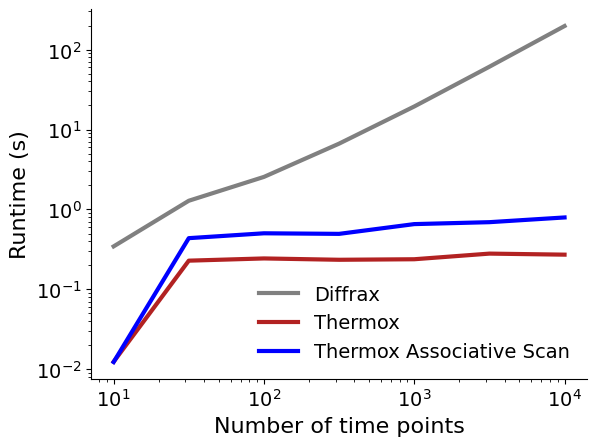

In [12]:
linewidth = 3
plt.plot(T_range, diffrax_times, label="Diffrax", color="grey", linewidth=linewidth)
plt.plot(T_range, thermox_times, label="Thermox", color="firebrick", linewidth=linewidth)
plt.plot(T_range, thermox_as_times, label="Thermox Associative Scan", color="blue", linewidth=linewidth)

fontsize = 16
plt.xlabel("Number of time points", fontsize=fontsize)
plt.ylabel("Runtime (s)", fontsize=fontsize)

legend_fontsize = 14
plt.legend(frameon=False, fontsize=legend_fontsize)
plt.xscale("log")
plt.yscale("log")

ticks_fontsize = 14
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)


And there you have it! `thermox` is roughly constant with respect to the number of time points, because the computation is dominated by the diagonalisation that is performed at initialisation. For a small number of time points, performance is comparable, but `thermox` really starts to shine for $\sim 10000$ time steps, where we get $\sim 800\times$ speedup with respect to `diffrax`, as well as being exact!

In [15]:
print(diffrax_times)
print(thermox_times)
print(thermox_as_times)

[0.34507107734680176, 1.285128116607666, 2.5552799701690674, 6.661646842956543, 19.432090997695923, 61.10534906387329, 197.41543078422546]
[0.012414932250976562, 0.22867178916931152, 0.24378585815429688, 0.23458290100097656, 0.23819899559020996, 0.2801799774169922, 0.27187585830688477]
[0.012326717376708984, 0.43737077713012695, 0.5031790733337402, 0.4949030876159668, 0.6556448936462402, 0.6931350231170654, 0.7941479682922363]


In [16]:
diffrax_times[-1]/thermox_times[-1], diffrax_times[-1]/thermox_as_times[-1]

(726.1234300597196, 248.58771748639555)